## Import data set and prepare feature and label sets

In [5]:
import pandas as pd

data = pd.read_csv('data/prepared_data.csv')

X = data[['review_id','text','cool','useful','funny','rating']]
y = data['rating']

## Encode and categorize labels

In [6]:
from sklearn import preprocessing
from keras.utils import to_categorical

encoder = preprocessing.LabelEncoder()
y = encoder.fit_transform(y)

y = to_categorical(y)

Using TensorFlow backend.


## Split data into Training and Test sets

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Preprocess textual feature

In [10]:
import re

def preprocess(s):
    sentence = re.sub('[^a-zA-Z]', ' ', s)
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence

X1_train = []
sentences = list(X_train['text'])
for s in sentences:
    X1_train.append(preprocess(s))
    
X1_test = []
sentences = list(X_test['text'])
for s in sentences:
    X1_test.append(preprocess(s))

## Vectorize textual feature

In [11]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from numpy import asarray, zeros

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X1_train)

X1_train = tokenizer.texts_to_sequences(X1_train)
X1_test = tokenizer.texts_to_sequences(X1_test)

maxlen = 200

X1_train = pad_sequences(X1_train, padding='post', maxlen=maxlen)
X1_test = pad_sequences(X1_test, padding='post', maxlen=maxlen)

glove_file = open('data/glove.6B.100d.txt', encoding="utf8")

embedding_dictionary = dict()
for line in glove_file:
    records = line.split()
    word = records[0]
    vector = asarray(records[1:], dtype='float32')
    embedding_dictionary[word] = vector
glove_file.close()

vocab_size = len(tokenizer.word_index) + 1

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    vector = embedding_dictionary.get(word)
    if vector is not None:
        embedding_matrix[index] = vector

## Extract metadata features

In [12]:
X2_train = X_train[['useful', 'funny', 'cool']].values
X2_test = X_test[['useful', 'funny', 'cool']].values

## Create sub-models with textual and meta inputs

In [13]:
from keras.layers import Input, LSTM
from keras.layers.embeddings import Embedding
from keras.layers.core import Dense

input_text = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(input_text)
LSTM_layer = LSTM(128)(embedding_layer)

input_meta = Input(shape=(3,))
dense_layer_1 = Dense(10, activation='relu')(input_meta)
dense_layer_2 = Dense(10, activation='relu')(dense_layer_1)

## Create model with joined outputs from sub-models

In [15]:
from keras.layers.merge import Concatenate
from keras.models import Model

concat_layer = Concatenate()([LSTM_layer, dense_layer_2])
dense_layer_3 = Dense(10, activation='relu')(concat_layer)
output = Dense(3, activation='softmax')(dense_layer_3)

model = Model(inputs=[input_text, input_meta], outputs=output)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200)          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 3)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 200, 100)     2602400     input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 10)           40          input_2[0][0]                    
____________________________________________________________________________________________

## Train the model

In [17]:
trained_model = model.fit(x=[X1_train, X2_train], y=y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.2)

Train on 6400 samples, validate on 1600 samples
Epoch 1/10
6400/6400 [==============================] - 27s 4ms/step - loss: 0.8816 - acc: 0.6381 - val_loss: 0.7818 - val_acc: 0.6931
Epoch 2/10
6400/6400 [==============================] - 25s 4ms/step - loss: 0.7996 - acc: 0.6798 - val_loss: 0.7771 - val_acc: 0.6931
Epoch 3/10
6400/6400 [==============================] - 26s 4ms/step - loss: 0.7947 - acc: 0.6798 - val_loss: 0.7760 - val_acc: 0.6931
Epoch 4/10
6400/6400 [==============================] - 28s 4ms/step - loss: 0.7880 - acc: 0.6798 - val_loss: 0.7737 - val_acc: 0.6944
Epoch 5/10
6400/6400 [==============================] - 27s 4ms/step - loss: 0.7841 - acc: 0.6811 - val_loss: 0.7679 - val_acc: 0.6931
Epoch 6/10
6400/6400 [==============================] - 27s 4ms/step - loss: 0.7765 - acc: 0.6819 - val_loss: 0.7618 - val_acc: 0.6906
Epoch 7/10
6400/6400 [==============================] - 27s 4ms/step - loss: 0.7714 - acc: 0.6848 - val_loss: 0.7632 - val_acc: 0.6919
Epoch 8

## Evaluate the model

In [18]:
score = model.evaluate(x=[X1_test, X2_test], y=y_test, verbose=1)

print('Test score:', score[0])
print('Test Accuracy:', score[1])

2000/2000 [==============================] - 3s 2ms/step
Test score: 0.7437094285488128
Test Accuracy: 0.703000009059906


## Plot loss and accuracy

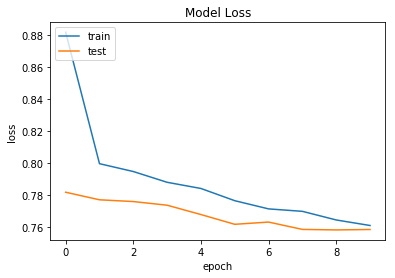

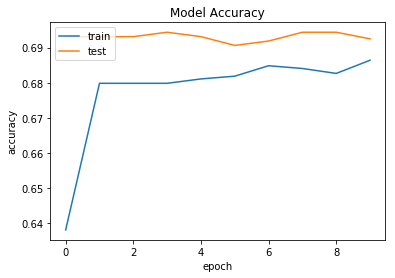

In [19]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.figure()
plt.plot(trained_model.history['acc'])
plt.plot(trained_model.history['val_acc'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','test'], loc='upper left')
plt.show()

## Save the model

In [20]:
import pickle

filename = 'model_multi.sav'
pickle.dump(model, open(filename, 'wb'))